In [119]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# !pip install chart_studio
# !pip install textstat

import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
import textstat

# Visualisation libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# File system manangement
import os

# Pytorch
import torch

#Transformers
from transformers import BertTokenizer

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import BertTokenizer,BertConfig,TFBertModel
from tqdm import tqdm

Using TensorFlow backend.


ImportError: cannot import name 'tf_utils'

In [38]:
# 二つの文章にどれだけ同じ言葉が含まれているかを調べるメソッド
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


Sentence_1 = 'Life well spent is life good'
Sentence_2 = 'Life is an art and it is good so far'
Sentence_3 = 'Life is good'

    
print(jaccard(Sentence_1,Sentence_2))
print(jaccard(Sentence_1,Sentence_3))

0.2727272727272727
0.6


In [8]:
# データの読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (27481, 4)
Testing data shape:  (3534, 3)


In [9]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [13]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [14]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [16]:
# 欠損しているデータを削除
train.dropna(axis = 0, how ='any',inplace=True) ;
train.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [17]:
# Positive tweet
print("Positive Tweet example :",train[train['sentiment']=='positive']['text'].values[0])
# negative_text
print("Negative Tweet example :",train[train['sentiment']=='negative']['text'].values[0])
# neutral_text
print("Neutral tweet example  :",train[train['sentiment']=='neutral']['text'].values[0])

Positive Tweet example : 2am feedings for the baby are fun when he is all smiles and coos
Negative Tweet example :  Sooo SAD I will miss you here in San Diego!!!
Neutral tweet example  :  I`d have responded, if I were going


In [18]:
train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [19]:
# 出現数を％で表示
train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

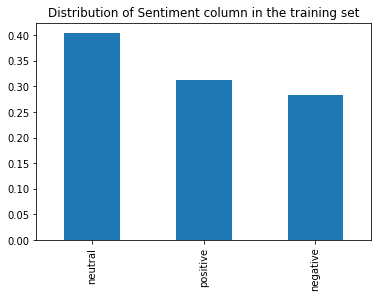

In [45]:
train['sentiment'].value_counts(normalize=True).plot(kind='bar',title='Distribution of Sentiment column in the training set')

In [36]:
# clean_text（）関数は、最初のラウンドのテキストクリーニング手法を適用する。
# text_preprocessing（）関数は、clean_text（）関数から処理済みのテキストを取り込み、
# トークン化やストップワードの削除などの手法を適用する。
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [46]:
# 訓練データとテストデータをクリーンアップ
train['text_clean'] = train['text'].apply(str).apply(lambda x: text_preprocessing(x))
test['text_clean'] = test['text'].apply(str).apply(lambda x: text_preprocessing(x))

In [47]:
train.head()

,textID,text,selected_text,sentiment,text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...


In [48]:
# テキストの長さ
train['text_len'] = train['text_clean'].astype(str).apply(len)
# 単語の数
train['text_word_count'] = train['text_clean'].apply(lambda x: len(str(x).split()))

In [49]:
train.head()

,textID,text,selected_text,sentiment,text_clean,text_len,text_word_count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,33,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,42,10
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,22,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,29,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...,67,13


In [52]:
# 感情ごとにデータを分ける
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']
neutral = train[train['sentiment']=='neutral']

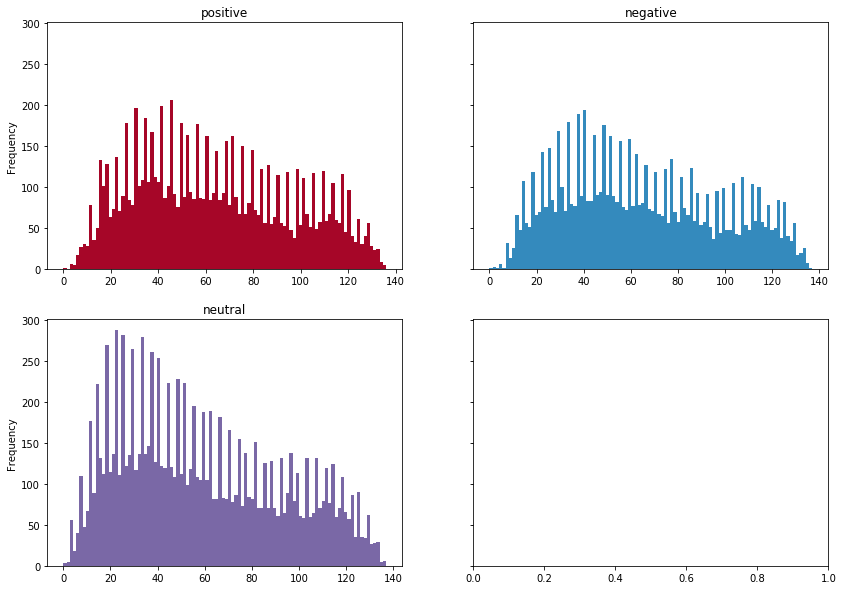

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# ポジティブ
pos['text_len'].plot(
    kind='hist', bins=100, color='#A60628', title='positive', ax=axes.flatten()[0])

# ネガティブ
neg['text_len'].plot(
    kind='hist', bins=100, color='#348ABD', title='negative', ax=axes.flatten()[1])

# 中立
neutral['text_len'].plot(
    kind='hist', bins=100, color='#7A68A6', title='neutral', ax=axes.flatten()[2])

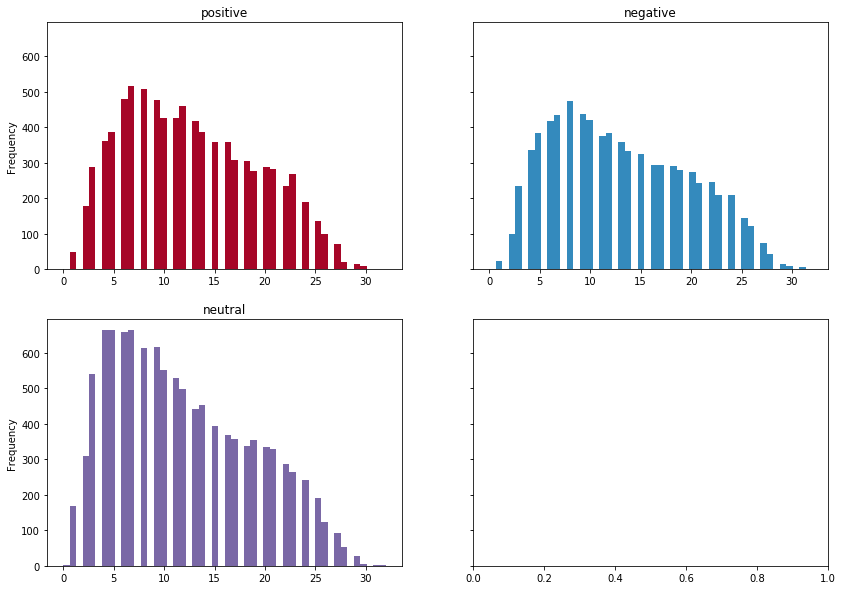

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# ポジティブ
pos['text_word_count'].plot(
    kind='hist', bins=50, color='#A60628', title='positive', ax=axes.flatten()[0])

# ネガティブ
neg['text_word_count'].plot(
    kind='hist', bins=50, color='#348ABD', title='negative', ax=axes.flatten()[1])

# 中立
neutral['text_word_count'].plot(
    kind='hist', bins=50, color='#7A68A6', title='neutral', ax=axes.flatten()[2])

In [82]:
# 単語の出現数のランキング
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

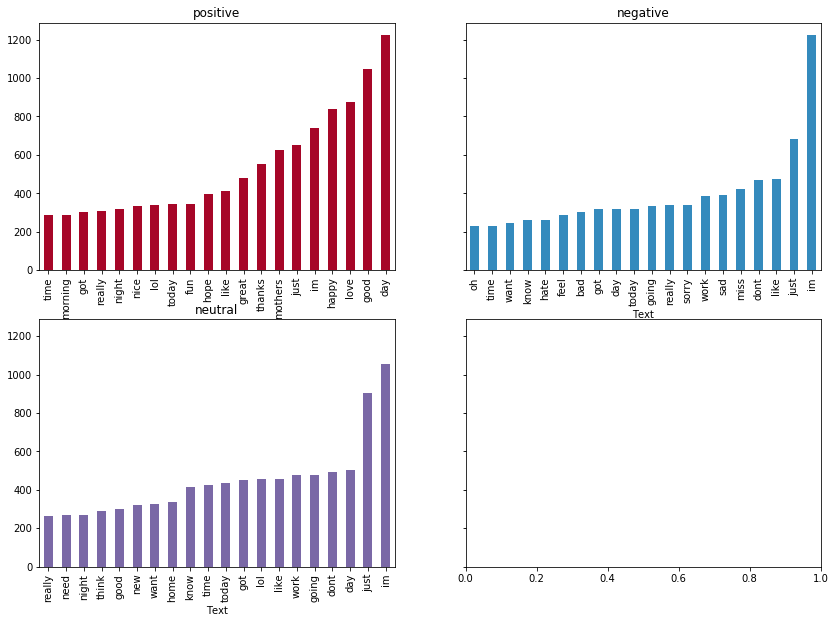

In [89]:
pos_unigrams = get_top_n_words(pos['text_clean'],20)
neg_unigrams = get_top_n_words(neg['text_clean'],20)
neutral_unigrams = get_top_n_words(neutral['text_clean'],20)



#for word, freq in top_unigrams:
    #print(word, freq)
    
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

df1 = pd.DataFrame(pos_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#A60628', title='positive', ax=axes.flatten()[0])

df2 = pd.DataFrame(neg_unigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#348ABD', title='negative', ax=axes.flatten()[1])

df3 = pd.DataFrame(neutral_unigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#7A68A6', title='neutral', ax=axes.flatten()[2])

In [90]:
# 出現 nグラムを取得
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

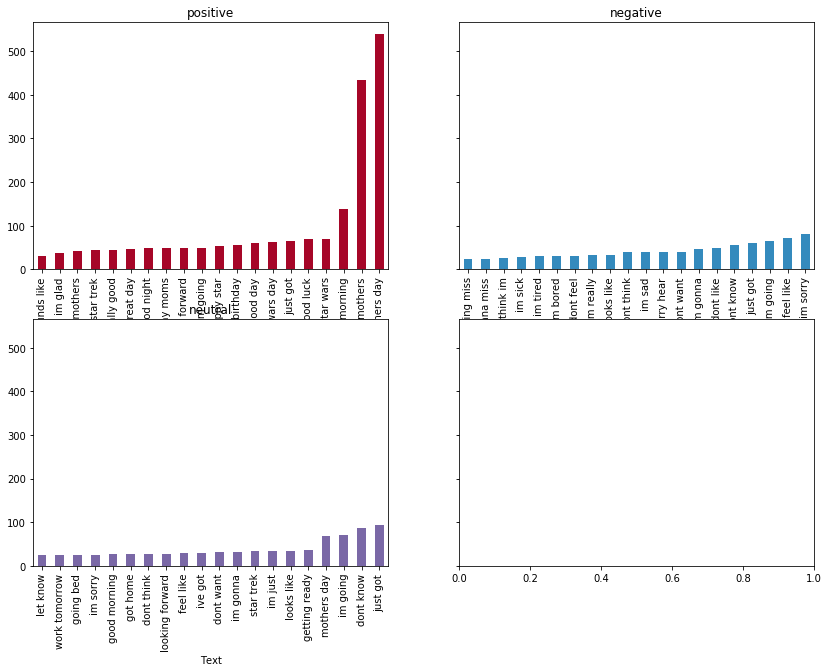

In [91]:
pos_bigrams = get_top_n_gram(pos['text_clean'],(2,2),20)
neg_bigrams = get_top_n_gram(neg['text_clean'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['text_clean'],(2,2),20)



#for word, freq in top_bigrams:
    #print(word, freq)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

df1 = pd.DataFrame(pos_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#A60628', title='positive', ax=axes.flatten()[0])

df2 = pd.DataFrame(neg_bigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#348ABD', title='negative', ax=axes.flatten()[1])

df3 = pd.DataFrame(neutral_bigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#7A68A6', title='neutral', ax=axes.flatten()[2])

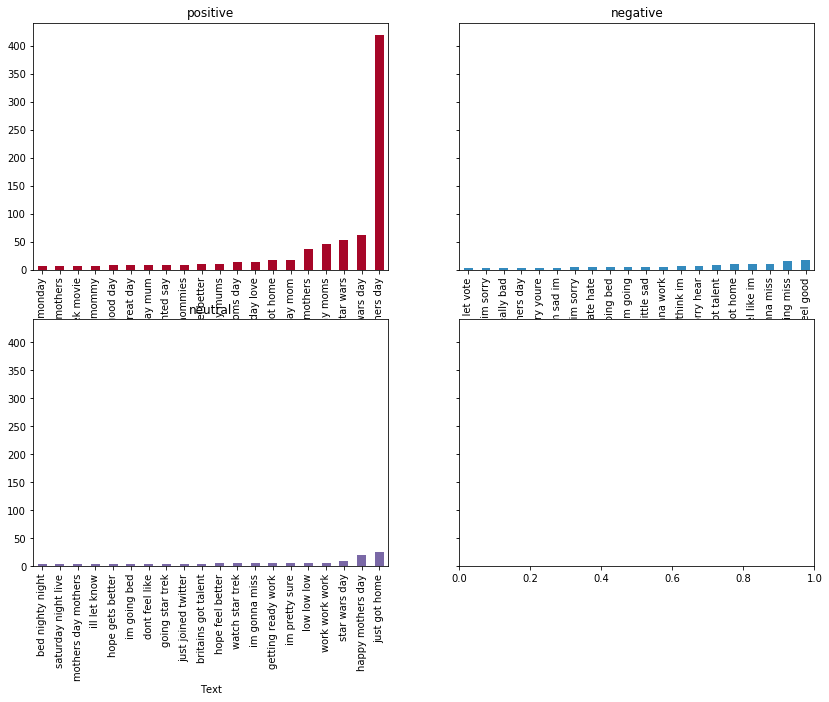

In [92]:
pos_trigrams = get_top_n_gram(pos['text_clean'],(3,3),20)
neg_trigrams = get_top_n_gram(neg['text_clean'],(3,3),20)
neutral_trigrams = get_top_n_gram(neutral['text_clean'],(3,3),20)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

df1 = pd.DataFrame(pos_trigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#A60628', title='positive', ax=axes.flatten()[0])

df2 = pd.DataFrame(neg_trigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#348ABD', title='negative', ax=axes.flatten()[1])

df3 = pd.DataFrame(neutral_trigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#7A68A6', title='neutral', ax=axes.flatten()[2])

In [93]:
# selected_textについて
positive_text = train[train['sentiment'] == 'positive']['selected_text']
negative_text = train[train['sentiment'] == 'negative']['selected_text']
neutral_text = train[train['sentiment'] == 'neutral']['selected_text']

In [94]:
# Positive text
print("Positive Text example :",positive_text.values[0])
#negative_text
print("Negative Tweet example :",negative_text.values[0])
#neutral_text
print("Neutral tweet example  :",neutral_text.values[0])

Positive Text example : fun
Negative Tweet example : Sooo SAD
Neutral tweet example  : I`d have responded, if I were going


In [95]:
positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

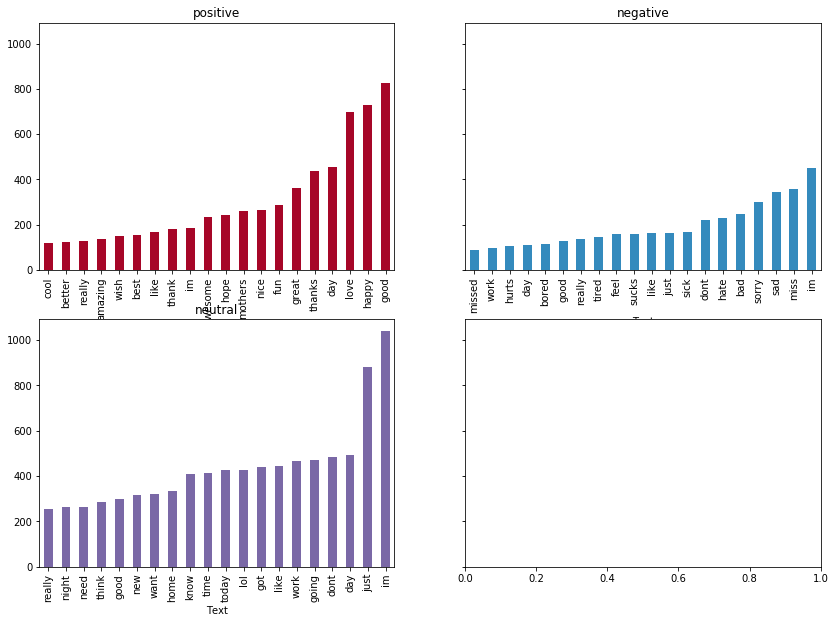

In [101]:
top_words_in_positive_text = get_top_n_words(positive_text_clean,20)
top_words_in_negative_text = get_top_n_words(negative_text_clean,20)
top_words_in_neutral_text = get_top_n_words(neutral_text_clean,20)

#for word, freq in top_unigrams:
    #print(word, freq)
    
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

df1 = pd.DataFrame(top_words_in_positive_text, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#A60628', title='positive', ax=axes.flatten()[0])

df2 = pd.DataFrame(top_words_in_negative_text, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#348ABD', title='negative', ax=axes.flatten()[1])

df3 = pd.DataFrame(top_words_in_neutral_text, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='#7A68A6', title='neutral', ax=axes.flatten()[2])

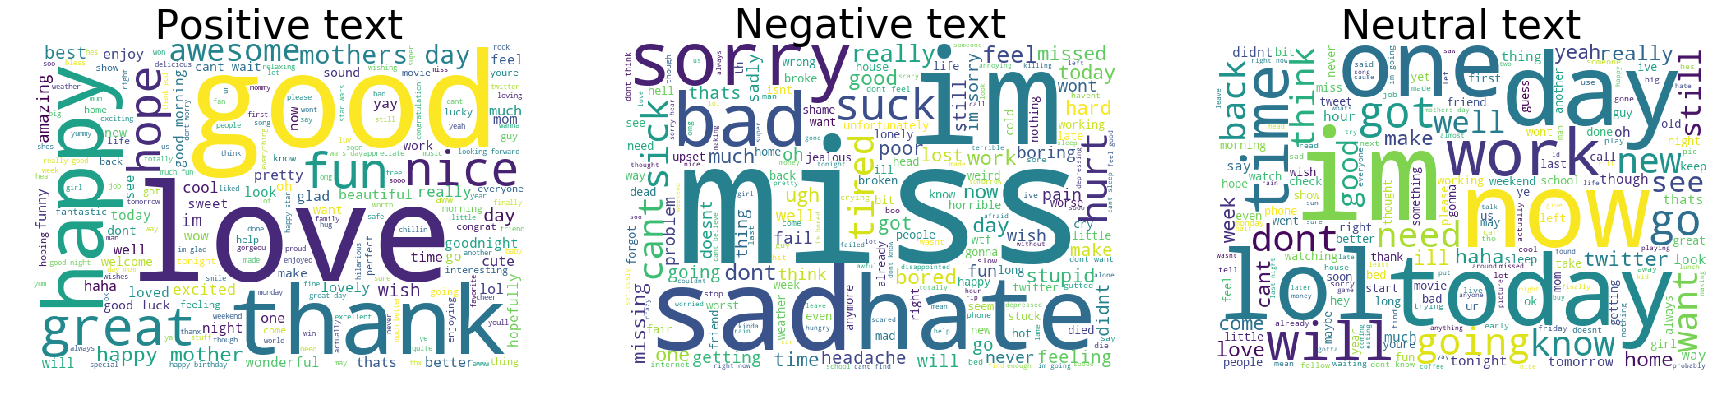

In [103]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40);

In [107]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

I0419 15:12:32.183362  2096 filelock.py:274] Lock 2017584870904 acquired on C:\Users\fujii\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
I0419 15:12:32.186390  2096 file_utils.py:479] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to C:\Users\fujii\.cache\torch\transformers\tmp5epiyb1h


I0419 15:12:38.549878  2096 file_utils.py:489] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt in cache at C:\Users\fujii\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0419 15:12:38.552905  2096 file_utils.py:492] creating metadata file for C:\Users\fujii\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0419 15:12:38.555863  2096 filelock.py:318] Lock 2017584870904 released on C:\Users\fujii\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
I0419 15:12:38.557854  2096 tokenization_utils.py:504] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\fujii\.cache\t

In [109]:
# Tokenization using Hugging face Transformers

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenizing the first text
print(train['text'][10]) # original sentence
print(tokenizer.tokenize(train['text'][10], add_special_tokens=True))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train['text'][10])))

I0419 15:21:44.964981  2096 tokenization_utils.py:504] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\fujii\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


 as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
['as', 'much', 'as', 'i', 'love', 'to', 'be', 'hopeful', ',', 'i', 'reckon', 'the', 'chances', 'are', 'minimal', '=', 'p', 'i', '`', 'm', 'never', 'gonna', 'get', 'my', 'cake', 'and', 'stuff']
[2004, 2172, 2004, 1045, 2293, 2000, 2022, 17772, 1010, 1045, 29072, 1996, 9592, 2024, 10124, 1027, 1052, 1045, 1036, 1049, 2196, 6069, 2131, 2026, 9850, 1998, 4933]


In [110]:
# ゼロパディングのためにテキストの最長値を取得

max_len = 0

for text in train['text']:

    # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))


print('Max length: ', max_len)

Max length:  110


In [111]:
text = train['text'].values
sentiment = train['sentiment'].values

input_ids = []
attention_masks = []
token_type_ids = []

for i in range(len(text)):
    encoded = tokenizer.encode_plus(
      sentiment[i],
      text[i],
      add_special_tokens=True,
      max_length=150,
      pad_to_max_length=True,
      return_token_type_ids=True,
      return_attention_mask=True,
      return_tensors='pt'
    )
    
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    token_type_ids.append(encoded['token_type_ids'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)

print('Original text: ',text[10])
print(input_ids[10])
print(attention_masks[10])
print(token_type_ids[10])

Original text:   as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
tensor([  101,  8699,   102,  2004,  2172,  2004,  1045,  2293,  2000,  2022,
        17772,  1010,  1045, 29072,  1996,  9592,  2024, 10124,  1027,  1052,
         1045,  1036,  1049,  2196,  6069,  2131,  2026,  9850,  1998,  4933,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    